<a href="https://colab.research.google.com/github/raniaAprilia/Capstone_Project-ML/blob/main/FaceShape_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import os
from google.colab import files
import pandas as pd
import cv2
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

In [ ]:
upload = files.upload()
# from google.colab import drive
# drive.mount('/content/drive')

Saving face-shape-dataset-metadata.json to face-shape-dataset-metadata.json


In [ ]:
if not os.path.exists('/root/.kaggle'):
  os.makedirs('/root/.kaggle')

!mv face-shape-dataset-metadata.json /root/.kaggle/
!chmod 600 /root/face-shape-dataset-metadata.json
# import zipfile

# # Specify the path to the ZIP file
# zip_path = '/content/drive/MyDrive/archive.zip'

# # Extract the ZIP file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall('/content/')


chmod: cannot access '/root/face-shape-dataset-metadata.json': No such file or directory


In [ ]:
!kaggle datasets download -d niten19/face-shape-dataset

Dataset URL: https://www.kaggle.com/datasets/niten19/face-shape-dataset
License(s): CC0-1.0
 99% 636M/639M [00:08<00:00, 90.9MB/s]
100% 639M/639M [00:08<00:00, 82.3MB/s]


In [ ]:
!unzip face-shape-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (161).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (163).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (189).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (192).jpg  
  inflating:

In [ ]:
class_names=['Heart', 'Oblong', 'Oval', 'Round', 'Square']
lable = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes= len(class_names)
IMAGE_SIZE=(150, 150)

In [ ]:
def load_data():
  datasets =['/content/FaceShape Dataset/training_set','/content/FaceShape Dataset/testing_set']
  output = []

  for dataset in datasets:
    images = []
    labels = []

    print("Loading {}.".format(dataset))
    for folder in os.listdir(dataset):
      if folder != "desktop.ini":
        label = lable[folder]
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
          if file != "desktop.ini":
            img = os.path.join(os.path.join(dataset, folder), file)
            try:
              image = cv2.imread(img)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, IMAGE_SIZE)
              images.append(image)
              labels.append(label)
            except Exception as e:
              print(f"Broken: {img}")
    images = np.array(images, dtype ='float32')
    labels = np.array(labels, dtype='int32')
    output.append((images, labels))
  return output


In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/FaceShape Dataset/training_set.


 82%|████████▏ | 656/800 [00:09<00:03, 37.72it/s]

Broken: /content/FaceShape Dataset/training_set/Oblong/oblong (724).jpg


100%|██████████| 800/800 [00:14<00:00, 55.33it/s]


Loading /content/FaceShape Dataset/testing_set.


100%|██████████| 200/200 [00:02<00:00, 77.91it/s]


Gambar asli:


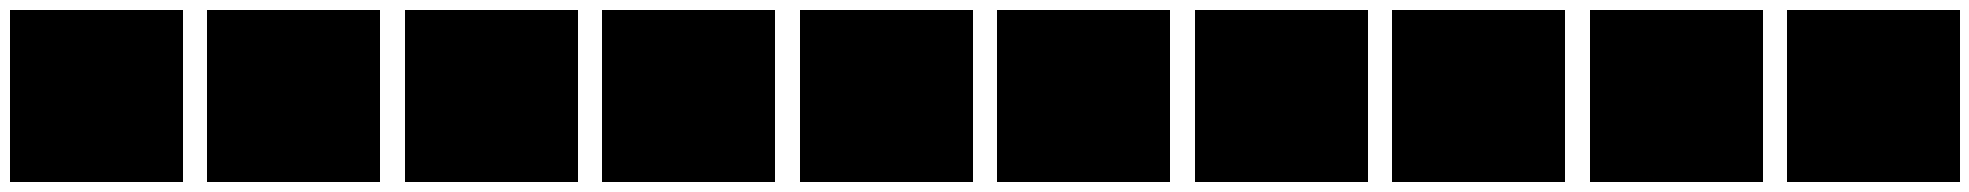

In [ ]:
# Menampilkan beberapa gambar asli sebelum augmentasi untuk verifikasi
def plot_images(images_arr, n_images=10):
    fig, axes = plt.subplots(1, n_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
print("Gambar asli:")
plot_images(X_train[:10])

In [ ]:
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train images shape: (3999, 150, 150, 3)
Train labels shape: (3999,)


In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

train_images = train_images / 255.0
test_images = test_images / 255.0

Number of training examples: 3999
Number of testing examples: 1000
Each image is of size: (150, 150)


In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(60, (5, 5), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(60, (5, 5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(30, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.Conv2D(30, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),

    # tf.keras.layers.Conv2D(40, (3, 3), activation = 'relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(30, (3, 3), activation = 'relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax),
    # tf.keras.layers.Dropout(0.5)

])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split = 0.2)

Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 5) are incompatible


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 146, 146, 60)      4560      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 73, 73, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 69, 69, 60)        90060     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 34, 34, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 30)        16230     
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 30)       

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

In [ ]:
def display_random_image(class_names, images, labels):
    """
    #Exibição de uma imagem aleatória
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [ ]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)
# Recall
from sklearn.metrics import recall_score
recall_score(test_labels, pred_labels, average=None)
# Precision
from sklearn.metrics import precision_score
precision_score(test_labels, pred_labels, average=None)

#f1-score
from sklearn.metrics import f1_score
f1_score(test_labels, pred_labels, average=None)

#Classification Report
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(test_labels, pred_labels, target_names=class_names))